# Using sklearn to Predict Titanic Survivors
Hi, I'm a new Kaggle user as well as a current undergraduate interested in the Data Science and Machine Learning field. In this Kernel, I will try to step by step build a ML model using sklearn to predict the outcomes of each passenger aboard the titanic. Please upvote and share if this helps!! Always looking for suggestions and recommendations. Thank You!

# Contents
1. Importing Libraries and Packages
2. Loading and Viewing Data Set
3. Dealing with NaN Values
4. Plotting and Visualizing Data
5. Feature Engineering
6. Modeling and Predicting with sklearn
7. Evaluating Model Performances
8. Submission

# 1. Importing Libraries and Packages
We will use these packages to help us manipulate the data and visualize the features/labels as well as measure how well our model performed.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sb
from matplotlib import pyplot as plt
%matplotlib inline #display and return graphs

sb.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

UsageError: unrecognized arguments: #display and return graphs


# 2. Loading and Viewing Data Set
With Pandas, we can load both the training and testing set that we wil later use to train and test our model. Before we begin, we should take a look at our data table to see the values that we'll be working with.

In [2]:
training = pd.read_csv('../input/train.csv')
testing = pd.read_csv('../input/test.csv')

In [3]:
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
print(training.keys())
print(testing.keys())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


# 3. Dealing with NaN Values
There are NaN values in our data set in the age column. Furthermore, the Cabin and Name column are useless because they aren't good features that we can use to predict survival. We can just drop them as well as the NaN values which will get in the way of training. We also need to fill in the NaN values with median values in order for the model to have a complete prediction for every row in the data set.

In [7]:
def null_table(training, testing):
    print("Training Data Frame")
    print(pd.isnull(training).sum()) 
    print(" ")
    print("Testing Data Frame")
    print(pd.isnull(testing).sum())

null_table(training, testing)

Training Data Frame
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
 
Testing Data Frame
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [8]:
training.drop(labels = ['Cabin', 'Ticket'], axis = 1, inplace = True)
testing.drop(labels = ['Cabin', 'Ticket'], axis = 1, inplace = True)

null_table(training, testing)

Training Data Frame
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64
 
Testing Data Frame
PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


In [9]:
#the median will be an acceptable value to place in the NaN cells
training['Age'].fillna(training['Age'].median(), inplace = True)
testing["Age"].fillna(testing["Age"].median(), inplace = True) 
training["Embarked"].fillna("S", inplace = True)
testing["Fare"].fillna(testing["Fare"].median(), inplace = True)

null_table(training, testing)

Training Data Frame
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
 
Testing Data Frame
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


# 4. Plotting and Visualizing Data
It is very important to understand and visualize any data we are going to use in a machine learning model. By visualizing, we can see the trends and general associations of variables like Sex and Age with survival rate. We can make several different graphs for each feature we want to work with to see the entropy and information gain of the feature. 

**Gender **

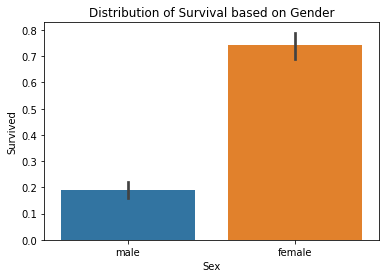

Proportion of Females who survived:
0.6812865497076024
Proportion of Males who survived:
0.31871345029239767


In [10]:
#can ignore the testing set for now
sb.barplot(x="Sex", y="Survived", data=training)
plt.title("Distribution of Survival based on Gender")
plt.show()

total_survived_females = training[training.Sex == "female"]["Survived"].sum()
total_survived_males = training[training.Sex == "male"]["Survived"].sum()

print("Proportion of Females who survived:") 
print(total_survived_females/(total_survived_females + total_survived_males))
print("Proportion of Males who survived:")
print(total_survived_males/(total_survived_females + total_survived_males))

Gender appears to be a very good feature to use to predict survival, as shown by the large difference in propotion survived. Let's take a look at how class plays a role in survival as well.

**Class**

Text(0.5,1,'Distribution of Survival Based on Class')

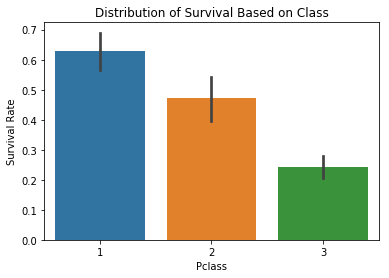

In [11]:
sb.barplot(x="Pclass", y="Survived", data=training)
plt.ylabel("Survival Rate")
plt.title("Distribution of Survival Based on Class")

Text(0.5,1,'Survival Rates Based on Gender and Class')

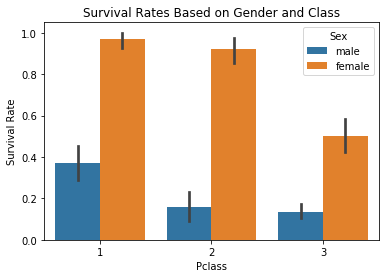

In [12]:
sb.barplot(x="Pclass", y="Survived", hue="Sex", data=training)
plt.ylabel("Survival Rate")
plt.title("Survival Rates Based on Gender and Class")

Text(0.5,1,'Survival Rates Based on Gender and Class')

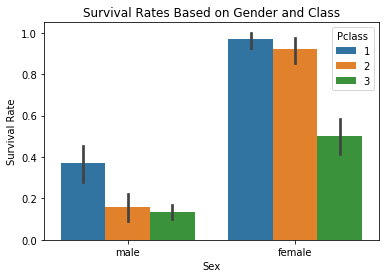

In [13]:
sb.barplot(x="Sex", y="Survived", hue="Pclass", data=training)
plt.ylabel("Survival Rate")
plt.title("Survival Rates Based on Gender and Class")

It appears that class also plays a role in survival, as shown by the bar graph. People in Pclass 1 were more likely to survive than people in the other 2 Pclasses.

**Age**

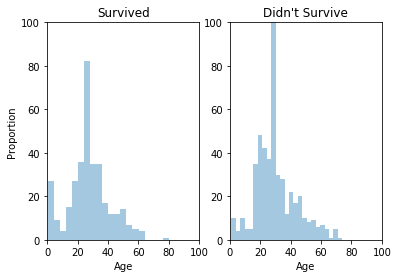

In [14]:
survived_ages = training[training.Survived == 1]["Age"]
not_survived_ages = training[training.Survived == 0]["Age"]
plt.subplot(1, 2, 1)
sb.distplot(survived_ages, kde=False)
plt.axis([0, 100, 0, 100])
plt.title("Survived")
plt.ylabel("Proportion")
plt.subplot(1, 2, 2)
sb.distplot(not_survived_ages, kde=False)
plt.axis([0, 100, 0, 100])
plt.title("Didn't Survive")
plt.show()

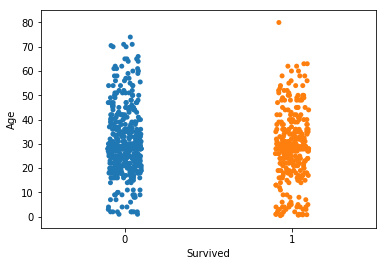

In [15]:
sb.stripplot(x="Survived", y="Age", data=training, jitter=True)

It appears as though passengers in the younger range of ages were more likely to survive than those in the older range of ages, as seen by the clustering in the strip plot, as well as the survival distributions of the histogram.

Here is one final cumulative graph of a pair plot that shows the relations between all of the different features

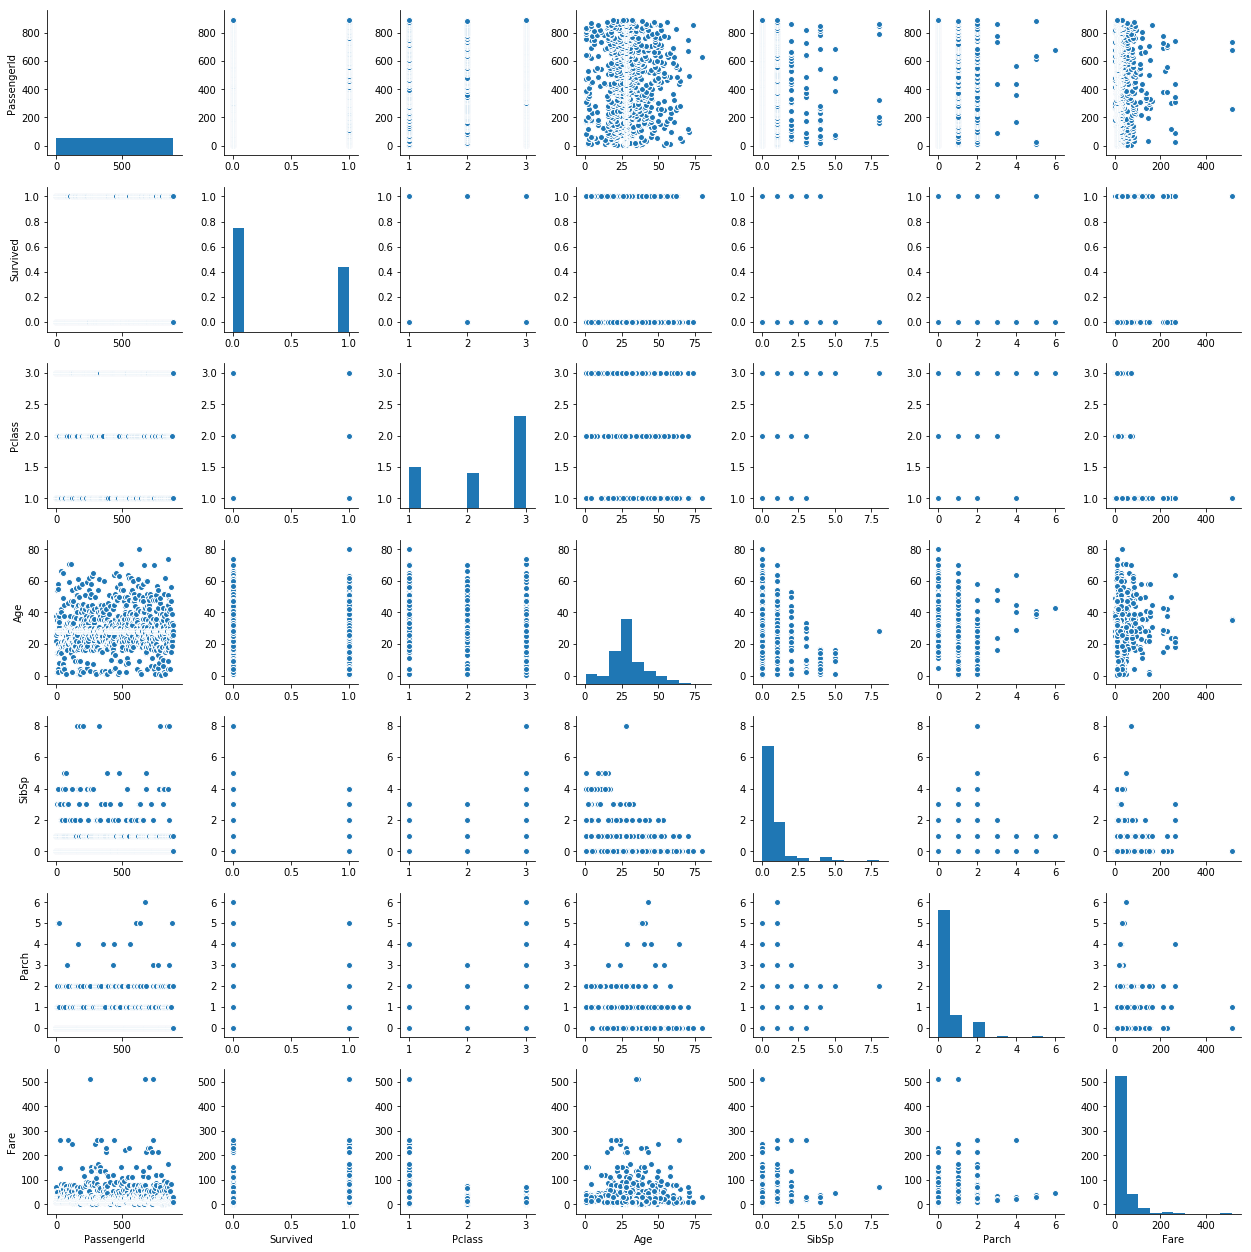

In [16]:
sb.pairplot(training)

# 5. Feature Engineering
Because values in columns like Sex and Embarked are categorical, we have to represent certain strings as numerical values in order to perform our classification with our model. 

In [17]:
training.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,13.0000,S
799,800,0,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,24.1500,S
138,139,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,9.2167,S
253,254,0,3,"Lobb, Mr. William Arthur",male,30.0,1,0,16.1000,S
460,461,1,1,"Anderson, Mr. Harry",male,48.0,0,0,26.5500,S


In [18]:
testing.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,27.0,0,0,31.6833,S
124,1016,3,"Kennedy, Mr. John",male,27.0,0,0,7.7500,Q
95,987,3,"Tenglin, Mr. Gunnar Isidor",male,25.0,0,0,7.7958,S
155,1047,3,"Duquemin, Mr. Joseph",male,24.0,0,0,7.5500,S
58,950,3,"Davison, Mr. Thomas Henry",male,27.0,1,0,16.1000,S


In [19]:
training.loc[training["Sex"] == "male", "Sex"] = 0
training.loc[training["Sex"] == "female", "Sex"] = 1

training.loc[training["Embarked"] == "S", "Embarked"] = 0
training.loc[training["Embarked"] == "C", "Embarked"] = 1
training.loc[training["Embarked"] == "Q", "Embarked"] = 2

testing.loc[testing["Sex"] == "male", "Sex"] = 0
testing.loc[testing["Sex"] == "female", "Sex"] = 1

testing.loc[testing["Embarked"] == "S", "Embarked"] = 0
testing.loc[testing["Embarked"] == "C", "Embarked"] = 1
testing.loc[testing["Embarked"] == "Q", "Embarked"] = 2

In [20]:
training.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
30,31,0,1,"Uruchurtu, Don. Manuel E",0,40.0,0,0,27.7208,1
737,738,1,1,"Lesurer, Mr. Gustave J",0,35.0,0,0,512.3292,1
405,406,0,2,"Gale, Mr. Shadrach",0,34.0,1,0,21.0000,0
510,511,1,3,"Daly, Mr. Eugene Patrick",0,29.0,0,0,7.7500,2
230,231,1,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",1,35.0,1,0,83.4750,0


We can combine SibSp and Parch into one synthetic feature called family size, which indicates the total number of family members on board for each member. 

In [21]:
training["FamSize"] = training["SibSp"] + training["Parch"] + 1
testing["FamSize"] = testing["SibSp"] + testing["Parch"] + 1

In [22]:
training["IsAlone"] = training.FamSize.apply(lambda x: 1 if x == 1 else 0)
testing["IsAlone"] = testing.FamSize.apply(lambda x: 1 if x == 1 else 0)

In [23]:
for name in training['Name']:
    training['Title'] = training['Name'].str.extract('([A-Za-z]+)\.',expand=True)
    
for name in testing['Name']:
    testing['Title'] = testing['Name'].str.extract('([A-Za-z]+)\.',expand=True)
    
title_replacements = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs', 'Rev' : 'Mr', 'Dr' : 'Mr', 'Master': 'Mr'}

training.replace({'Title': title_replacements}, inplace=True)
testing.replace({'Title': title_replacements}, inplace=True)

training.loc[training["Title"] == "Miss", "Title"] = 0
training.loc[training["Title"] == "Mr", "Title"] = 1
training.loc[training["Title"] == "Mrs", "Title"] = 2

testing.loc[testing["Title"] == "Miss", "Title"] = 0
testing.loc[testing["Title"] == "Mr", "Title"] = 1
testing.loc[testing["Title"] == "Mrs", "Title"] = 2

In [24]:
print(set(training["Title"]))

{0, 1, 2}


In [25]:
training.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamSize,IsAlone,Title
750,751,1,2,"Wells, Miss. Joan",1,4.0,1,1,23.0000,0,3,0,0
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",1,19.0,1,0,7.8542,0,2,0,0
433,434,0,3,"Kallio, Mr. Nikolai Erland",0,17.0,0,0,7.1250,0,1,1,1
392,393,0,3,"Gustafsson, Mr. Johan Birger",0,28.0,2,0,7.9250,0,3,0,1
860,861,0,3,"Hansen, Mr. Claus Peter",0,41.0,2,0,14.1083,0,3,0,1


# 6. Model Fitting and Predicting
Now that our data has been processed and formmated properly, and that we understand the general data we're working with as well as the trends and associations, we can start to build our model. We can import different classifiers from sklearn.

**sklearn Models to Test**

In [26]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [27]:
from sklearn.metrics import accuracy_score #to evaluate how well model is predicting 

In [28]:
from sklearn.model_selection import GridSearchCV

**Defining Features in Training/Test Set**

In [29]:
features = ["Pclass", "Sex", "Age", "Embarked", "Fare", "FamSize", "IsAlone"]
X_train = training[features] #define training features set
y_train = training["Survived"] #define training label set
X_test = testing[features] #define testing features set
#we don't have y_test, that is what we're trying to predict with our model

**Validation Data Set**

Although we already have a test set, it is generally easy to overfit the data with these classifiers. It is therefore useful to have a third data set called the validation data set to ensure that our model doesn't overfit with the data. We can make this third data set with sklearn's train_test_split function. We can also use the validation data set to test the general accuracy of our model.

In [30]:
from sklearn.model_selection import train_test_split #to create validation data set

X_training, X_valid, y_training, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0) #X_valid and y_valid are the validation sets

**SVC Model**

In [31]:
svc_clf = SVC(kernel="linear", gamma=3) #we can try different parameters
svc_clf.fit(X_training, y_training)
pred_svc = svc_clf.predict(X_valid)
acc_svc = accuracy_score(y_valid, pred_svc)

print(acc_svc)

0.7932960893854749


**LinearSVC Model**

In [32]:
linsvc_clf = LinearSVC()
linsvc_clf.fit(X_training, y_training)
pred_linsvc = linsvc_clf.predict(X_valid)
acc_linsvc = accuracy_score(y_valid, pred_linsvc)

print(acc_linsvc)

0.7932960893854749


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


**RandomForest Model**

In [33]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_training, y_training)
pred_rf = rf_clf.predict(X_valid)
acc_rf = accuracy_score(y_valid, pred_rf)

print(acc_rf)

0.8212290502793296


**LogisiticRegression Model**

In [34]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_training, y_training)
pred_logreg = logreg_clf.predict(X_valid)
acc_logreg = accuracy_score(y_valid, pred_logreg)

print(acc_logreg)

0.7988826815642458


**KNeighbors Model**

In [35]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_training, y_training)
pred_knn = knn_clf.predict(X_valid)
acc_knn = accuracy_score(y_valid, pred_knn)

print(acc_knn)

0.7318435754189944


**GaussianNB Model**

In [36]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_training, y_training)
pred_gnb = gnb_clf.predict(X_valid)
acc_gnb = accuracy_score(y_valid, pred_gnb)

print(acc_gnb)

0.8156424581005587


**DecisionTree Model**

In [37]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_training, y_training)
pred_dt = dt_clf.predict(X_valid)
acc_dt = accuracy_score(y_valid, pred_dt)

print(acc_dt)

0.8212290502793296


# 7. Evaluating Model Performances
After making so many models and predictions, we should evaluate and see which model performed the best and which model to use on our testing set.

In [38]:
model_performance = pd.DataFrame({
    'Model': ['SVC', 'Linear SVC', 'Random Forest', 
              'Logistic Regression', 'K Nearest Neighbors', 'Gaussian Naive Bayes',  
              'Decision Tree'],
    'Accuracy': [acc_svc, acc_linsvc, acc_rf, 
              acc_logreg, acc_knn, acc_gnb, acc_dt]
})

model_performance.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
2,Random Forest,0.821229
6,Decision Tree,0.821229
5,Gaussian Naive Bayes,0.815642
3,Logistic Regression,0.798883
0,SVC,0.793296
1,Linear SVC,0.793296
4,K Nearest Neighbors,0.731844


It appears that the Random Forest model works the best with our data so we will use it on the test set.

In [39]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# 8. Submission

In [40]:
submission_predictions = rf_clf.predict(X_test)

In [41]:
submission = pd.DataFrame({
        "PassengerId": testing["PassengerId"],
        "Survived": submission_predictions
    })

submission.to_csv("titanic.csv", index=False)
print(submission.shape)

(418, 2)
